In [14]:
import pandas as pd
import numpy as np
import copy
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from my_explainers import my_global_explainer, my_local_explainer, get_clusters
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [2]:
#import dataset
data = pd.read_csv("../datasets/income.csv")
data

Age          Workclass  Fnlwgt      Education  Education_Num  \
0      52   Self-emp-not-inc  209642        HS-grad              9   
1      31            Private   45781        Masters             14   
2      42            Private  159449      Bachelors             13   
3      37            Private  280464   Some-college             10   
4      30          State-gov  141297      Bachelors             13   
...   ...                ...     ...            ...            ...   
1595   66       Self-emp-inc  150726            9th              5   
1596   37            Private  123785        HS-grad              9   
1597   34            Private  289984        HS-grad              9   
1598   34                  ?  164309           11th              7   
1599   90            Private  137018        HS-grad              9   

           Marital_Status    Relationship                 Race      Sex  \
0      Married-civ-spouse         Husband                White     Male   
1           Never-married   Not-in-family                White   Female   
2      Married-civ-spouse         Husband                White     Male   
3      Married-civ-spouse         Husband                Black     Male   
4      Married-civ-spouse         Husband   Asian-Pac-Islander     Male   
...                   ...             ...                  ...      ...   
1595   Married-civ-spouse         Husband                White     Male   
1596        Never-married   Not-in-family                White     Male   
1597             Divorced       Unmarried                Black   Female   
1598   Married-civ-spouse            Wife                White   Female   
1599        Never-married   Not-in-family                White   Female   

      Capital_Gain  Capital_Loss  Hours_Per_Week  Income  
0                0             0              45    >50K  
1            14084             0              50    >50K  
2             5178             0              40    >50K  
3                0             0              80    >50K  
4                0             0              40    >50K  
...            ...           ...             ...     ...  
1595          1409             0               1   <=50K  
1596             0             0              75   <=50K  
1597             0             0              30   <=50K  
1598             0             0               8   <=50K  
1599             0             0              40   <=50K  

[1600 rows x 13 columns]

In [3]:
#save original data for later
original_data = copy.copy(data)
original_data = original_data.drop(columns=['Income'])

In [4]:
#encode categorical variables
columns = ['Workclass', 'Income', 'Sex', 'Marital_Status', 'Relationship', 'Race', 'Education']
for elem in columns:
    data=pd.get_dummies(data,columns=[elem],drop_first=True)
data

Age  Fnlwgt  Education_Num  Capital_Gain  Capital_Loss  Hours_Per_Week  \
0      52  209642              9             0             0              45   
1      31   45781             14         14084             0              50   
2      42  159449             13          5178             0              40   
3      37  280464             10             0             0              80   
4      30  141297             13             0             0              40   
...   ...     ...            ...           ...           ...             ...   
1595   66  150726              5          1409             0               1   
1596   37  123785              9             0             0              75   
1597   34  289984              9             0             0              30   
1598   34  164309              7             0             0               8   
1599   90  137018              9             0             0              40   

      Workclass_ Federal-gov  Workclass_ Local-gov  Workclass_ Private  \
0                          0                     0                   0   
1                          0                     0                   1   
2                          0                     0                   1   
3                          0                     0                   1   
4                          0                     0                   0   
...                      ...                   ...                 ...   
1595                       0                     0                   0   
1596                       0                     0                   1   
1597                       0                     0                   1   
1598                       0                     0                   0   
1599                       0                     0                   1   

      Workclass_ Self-emp-inc  ...  Education_ 9th  Education_ Assoc-acdm  \
0                           0  ...               0                      0   
1                           0  ...               0                      0   
2                           0  ...               0                      0   
3                           0  ...               0                      0   
4                           0  ...               0                      0   
...                       ...  ...             ...                    ...   
1595                        1  ...               1                      0   
1596                        0  ...               0                      0   
1597                        0  ...               0                      0   
1598                        0  ...               0                      0   
1599                        0  ...               0                      0   

      Education_ Assoc-voc  Education_ Bachelors  Education_ Doctorate  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     1                     0   
3                        0                     0                     0   
4                        0                     1                     0   
...                    ...                   ...                   ...   
1595                     0                     0                     0   
1596                     0                     0                     0   
1597                     0                     0                     0   
1598                     0                     0                     0   
1599                     0                     0                     0   

      Education_ HS-grad  Education_ Masters  Education_ Preschool  \
0                      1                   0                     0   
1                      0                   1                     0   
2                      0                   0                     0   
3                      0                   0                  

In [5]:
#create decoder for my_explainers
decoder = {
    'Sex': ['Sex_ Male'],
    'Workclass': ['Workclass_ Local-gov', 'Workclass_ Private', 'Workclass_ Self-emp-inc','Workclass_ Self-emp-not-inc', 'Workclass_ State-gov'],
    'Marital_Status': ['Marital_Status_ Married-AF-spouse','Marital_Status_ Married-civ-spouse','Marital_Status_ Married-spouse-absent','Marital_Status_ Never-married', 
                       'Marital_Status_ Separated','Marital_Status_ Widowed'],
    'Relationship':['Relationship_ Not-in-family','Relationship_ Other-relative', 'Relationship_ Own-child','Relationship_ Unmarried', 'Relationship_ Wife'],
    'Race': ['Race_ Asian-Pac-Islander', 'Race_ Black', 'Race_ Other', 'Race_ White'],
    'Education': ['Education_ 11th', 'Education_ 12th', 'Education_ 1st-4th','Education_ 5th-6th', 'Education_ 7th-8th', 'Education_ 9th', 'Education_ Assoc-acdm', 
                  'Education_ Assoc-voc','Education_ Bachelors', 'Education_ Doctorate', 'Education_ HS-grad', 'Education_ Masters','Education_ Preschool', 'Education_ Prof-school',
                  'Education_ Some-college']
}

In [6]:
X, y = data.loc[:, data.columns != 'Income_ >50K'], data['Income_ >50K']

#split in train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

#train random forest
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)

#get classification report
y_pred = rforest.predict(X_test)
print("Prcecision Score: {:.2f}".format(precision_score(y_test,y_pred))) 
print("Recall Score: {:.2f}".format(recall_score(y_test,y_pred))) 
print("F1 Score: {:.2f}".format(f1_score(y_test,y_pred))) 

Prcecision Score: 0.78
Recall Score: 0.86
F1 Score: 0.81


In [7]:
#create explainer and compute shap values
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X, check_additivity=False)

# load JS visualization code to notebook
shap.initjs()

In [8]:
prediction = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][prediction,:], X.iloc[prediction])

In [9]:
my_local_explainer(explainer.expected_value[1], shap_values[1], rforest, original_data, X, 1, decoder)

interactive(children=(BoundedIntText(value=0, description='Sample id:', layout=Layout(padding='10px 640px 0px …

In [10]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

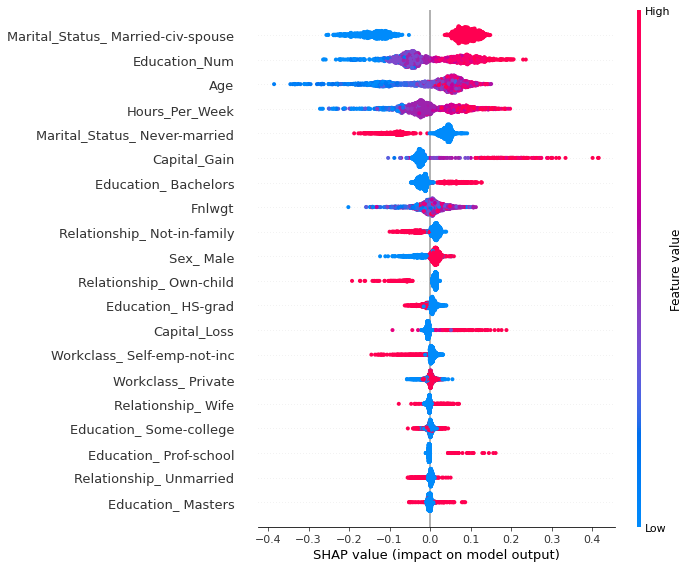

In [11]:
shap.summary_plot(shap_values[1], X)

In [12]:
my_global_explainer(explainer.expected_value[1], shap_values[1], rforest, original_data, X, 1, decoder)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Threshold for cluster forma…

In [16]:
cluster_data = get_clusters(explainer.expected_value[1], shap_values[1], rforest, original_data, X, 1, 0.23, decoder)
cluster_data[0]

Age          Workclass  Fnlwgt Education Education_Num  \
545   50            Private  156877      11th             7   
885   53            Private   95647       9th             5   
211   37            Private  186934      11th             7   
812   38            Private   28887      11th             7   
1465  48            Private  285335      11th             7   
...   ..                ...     ...       ...           ...   
331   61   Self-emp-not-inc   30073   HS-grad             9   
351   56   Self-emp-not-inc  145574   HS-grad             9   
397   44   Self-emp-not-inc  179557   HS-grad             9   
29    56   Self-emp-not-inc  335605   HS-grad             9   
422   51            Private  415287   HS-grad             9   

           Marital_Status Relationship    Race    Sex Capital_Gain  \
545    Married-civ-spouse      Husband   White   Male            0   
885    Married-civ-spouse      Husband   White   Male            0   
211    Married-civ-spouse      Husband   White   Male         3103   
812    Married-civ-spouse      Husband   White   Male            0   
1465   Married-civ-spouse      Husband   White   Male            0   
...                   ...          ...     ...    ...          ...   
331    Married-civ-spouse      Husband   White   Male            0   
351    Married-civ-spouse      Husband   White   Male            0   
397    Married-civ-spouse      Husband   White   Male            0   
29     Married-civ-spouse      Husband   White   Male            0   
422    Married-civ-spouse      Husband   Black   Male            0   

     Capital_Loss Hours_Per_Week  
545             0             70  
885             0             50  
211             0             44  
812             0             50  
1465            0             50  
...           ...            ...  
331          1848             60  
351          1902             60  
397          1977             45  
29           1887             50  
422          1902             40  

[138 rows x 12 columns]